In [91]:
import pandas as pd 

In [92]:
df = pd.read_excel('Realized Schedule 20210101-20220208.xlsx')

In [93]:
df.head()

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301


dividing timestamp into year, day and month.

In [94]:
df['year'] = df.ScheduleTime.apply(lambda x: x.year)
df['day'] = df.ScheduleTime.apply(lambda x: x.weekday())
df['month'] = df.ScheduleTime.apply(lambda x: x.month)

Binning the hours into 4 diffreent categories. 

In [95]:
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'daytime', 'afternoon']
df['time'] = pd.cut(df.ScheduleTime.dt.hour, bins,labels=labels)

In [96]:
df.head()

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,year,day,month,time
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451,2021,4,1,night
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189,2021,4,1,morning
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423,2021,4,1,morning
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333,2021,4,1,daytime
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301,2021,4,1,daytime


Dummy on sector, flighttype and time

In [97]:
df=pd.get_dummies(df,columns=['Sector','FlightType','time'],drop_first=True)

Cleaning a bit

In [99]:
df = df.drop('ScheduleTime', axis=1)

In [100]:
df

,Airline,FlightNumber,Destination,AircraftType,SeatCapacity,LoadFactor,year,day,month,Sector_CA,...,Sector_MX,Sector_NL,Sector_QA,Sector_SG,Sector_US,FlightType_G,FlightType_J,time_morning,time_daytime,time_afternoon
0,IA,874,DEN,73W,142,0.408451,2021,4,1,0,...,0,0,0,0,1,0,1,0,0,0
1,JZ,818,YHM,AT7,74,0.189189,2021,4,1,1,...,0,0,0,0,0,0,1,1,0,0
2,IA,876,DEN,73W,142,0.570423,2021,4,1,0,...,0,0,0,0,1,0,1,1,0,0
3,CN,514,EST,AT7,72,0.333333,2021,4,1,0,...,0,0,0,0,1,0,1,0,1,0
4,LJ,3140,DEN,32A,186,0.204301,2021,4,1,0,...,0,0,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36765,VW,986,YYZ,320,180,0.522222,2022,1,2,1,...,0,0,0,0,0,0,1,0,1,0
36766,LJ,579,YQU,319,156,0.532051,2022,1,2,1,...,0,0,0,0,0,0,1,0,0,1
36767,LJ,506,YUL,319,156,0.602564,2022,1,2,1,...,0,0,0,0,0,0,1,0,0,1
36768,CL,2708,DAN,73H,189,0.417989,2022,1,2,0,...,0,0,0,0,1,0,1,0,0,1


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

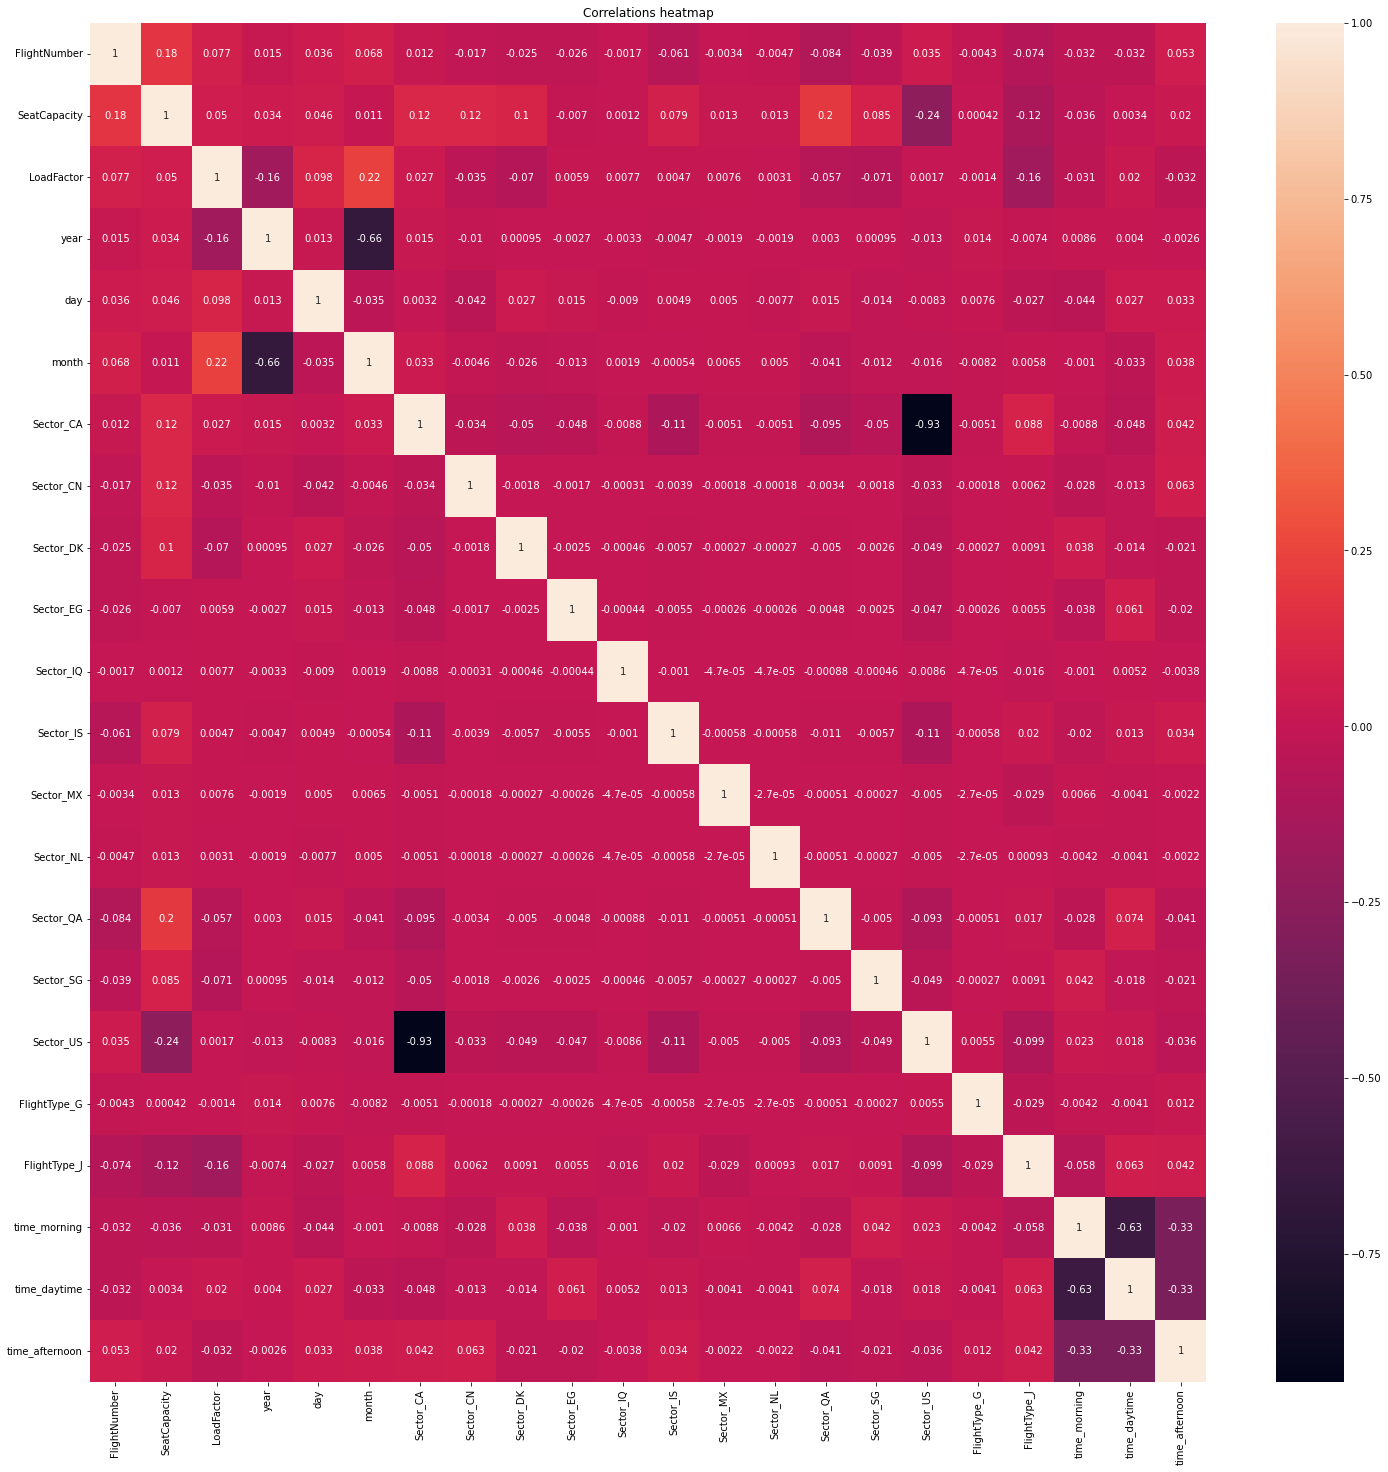

In [102]:
corr=df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr, annot=True)
plt.title("Correlations heatmap")
plt.show()